In [1]:
# Imports & paths
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
train_set = tf.keras.utils.image_dataset_from_directory(
    "train",
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 3528 files belonging to 7 classes.


In [3]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    "validation",
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)


Found 336 files belonging to 7 classes.


In [4]:
test_set = tf.keras.utils.image_dataset_from_directory(
    "test",
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 144 files belonging to 7 classes.


In [5]:
# Normalization
norm = tf.keras.layers.Rescaling(1./255)

train_ds = train_set.map(lambda x, y: (norm(x), y))
val_ds   = validation_set.map(lambda x, y: (norm(x), y))
test_ds  = test_set.map(lambda x, y: (norm(x), y))

In [6]:
# Performance optimization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


Build EfficientNet-B0 model

In [7]:
# Build EfficientNet-B0 model
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = train_ds.element_spec[1].shape[-1]  # auto-detect classes

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [8]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        "efficientnet_b0_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [10]:
_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)



Epoch 1/25


110/111 [============================>.] - ETA: 0s - loss: 1.9489 - accuracy: 0.1386
Epoch 1: val_accuracy did not improve from 0.14286
111/111 [==============================] - 11s 90ms/step - loss: 1.9489 - accuracy: 0.1389 - val_loss: 1.9459 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 2/25
110/111 [============================>.] - ETA: 0s - loss: 1.9462 - accuracy: 0.1415
Epoch 2: val_accuracy did not improve from 0.14286
111/111 [==============================] - 10s 86ms/step - loss: 1.9462 - accuracy: 0.1417 - val_loss: 1.9459 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 3/25
110/111 [============================>.] - ETA: 0s - loss: 1.9461 - accuracy: 0.1423
Epoch 3: val_accuracy did not improve from 0.14286
111/111 [==============================] - 10s 87ms/step - loss: 1.9461 - accuracy: 0.1420 - val_loss: 1.9459 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 4/25
110/111 [============================>.] - ETA: 0s - loss: 1.9461 - accuracy: 0.1480
Epoch 4: val_accuracy did not improv

In [12]:
# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

print("Fine-tuning completed")


Epoch 1/10
110/111 [============================>.] - ETA: 0s - loss: 1.9496 - accuracy: 0.1420
Epoch 1: val_accuracy did not improve from 0.14881
111/111 [==============================] - 15s 101ms/step - loss: 1.9496 - accuracy: 0.1420 - val_loss: 1.9457 - val_accuracy: 0.1280 - lr: 1.0000e-05
Epoch 2/10
110/111 [============================>.] - ETA: 0s - loss: 1.9488 - accuracy: 0.1489
Epoch 2: val_accuracy did not improve from 0.14881
111/111 [==============================] - 11s 92ms/step - loss: 1.9488 - accuracy: 0.1491 - val_loss: 1.9457 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 3/10
110/111 [============================>.] - ETA: 0s - loss: 1.9483 - accuracy: 0.1395
Epoch 3: val_accuracy did not improve from 0.14881
111/111 [==============================] - 10s 92ms/step - loss: 1.9482 - accuracy: 0.1395 - val_loss: 1.9457 - val_accuracy: 0.1339 - lr: 1.0000e-05
Epoch 4/10
110/111 [============================>.] - ETA: 0s - loss: 1.9492 - accuracy: 0.1403
Epoch 4: val

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


5/5 [==============================] - 1s 62ms/step - loss: 1.9460 - accuracy: 0.1389
Test accuracy: 0.1388888955116272


5/5 [==============================] - 1s 102ms/step
Classification Report:
                         precision    recall  f1-score   support

Atrial_fibrillation(AF)       0.00      0.00      0.00        20
                   LBBB       0.14      1.00      0.24        20
                 Normal       0.00      0.00      0.00        20
                    PAC       0.00      0.00      0.00        20
                    PVC       0.00      0.00      0.00        20
                   RBBB       0.00      0.00      0.00        24
                    STD       0.00      0.00      0.00        20

               accuracy                           0.14       144
              macro avg       0.02      0.14      0.03       144
           weighted avg       0.02      0.14      0.03       144



c:\Users\DELL\miniconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\miniconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\miniconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

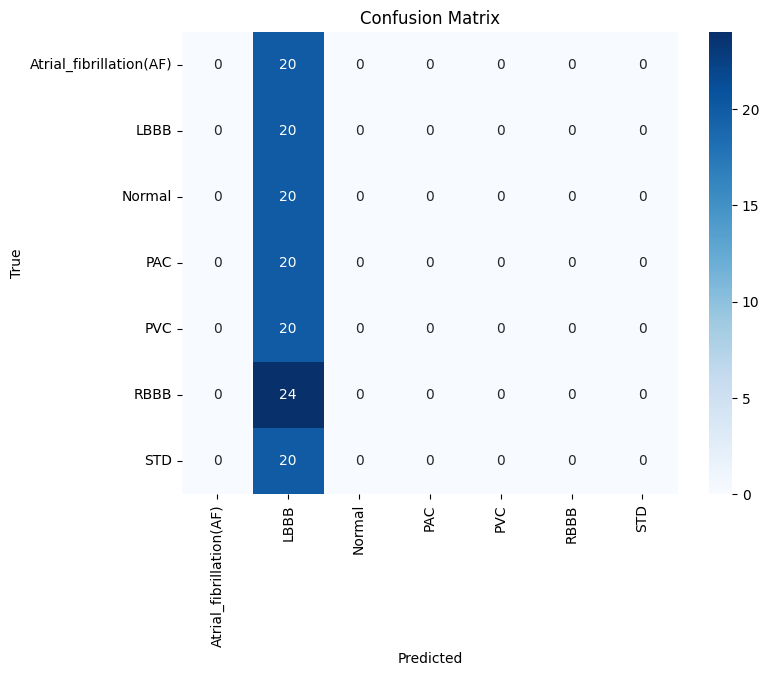

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define class names safely
CLASS_NAMES = train_set.class_names

# Predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=CLASS_NAMES
))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
